In [1]:
import pandas as pd
#import sklearn
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from pprint import pprint
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pickle
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
import warnings

pd.options.mode.chained_assignment = None  # default='warn'
shap.initjs()

/Users/marcloeffke/anaconda3/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df = pd.read_csv('data/US/counties.csv')
df = df.rename(columns = lambda x: x.lower().replace('-','_'))
df_16 = df[df.year == 2016]
df_16.dropna(inplace=True)
df_16.reset_index(inplace = True)
#df_16 = sklearn.utils.shuffle(df_16, random_state=42)

In [3]:
# Incorporate public health insurance
df_pubhealth = pd.read_csv('data/census/ALLOCATION OF PUBLIC HEALTH INSURANCE/ACS_16_5YR_B992703_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_pubhealth.columns = df_pubhealth.columns.droplevel(0)
renames = {}
for col in df_pubhealth.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]

df_pubhealth = df_pubhealth.rename(columns = renames)
drops = ['Id','Geography','Total','Total_No_public_coverage_items_allocated']
df_pubhealth.drop(drops, axis=1, inplace=True)
df_pubhealth.dropna(inplace=True)

In [4]:
df_16 = pd.merge(df_16, df_pubhealth, how = 'inner', left_on= 'geoid', right_on= 'Id2')
df_16['pct_public_health_insurance'] = df_16['Total_One_or_more_public_coverage_items_allocated']/df_16['population']
df_16.drop('Total_One_or_more_public_coverage_items_allocated', axis=1, inplace=True)

In [5]:
# Incorporate private health insurance
df_privhealth = pd.read_csv('data/census/ALLOCATION OF PRIVATE HEALTH INSURANCE/ACS_16_5YR_B992702_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_privhealth.columns = df_privhealth.columns.droplevel(0)
renames = {}
for col in df_privhealth.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]

df_privhealth = df_privhealth.rename(columns = renames)
drops = ['Id','Geography','Total','Total_No_private_health_insurance_items_allocated']
df_privhealth.drop(drops, axis=1, inplace=True)
df_privhealth.dropna(inplace=True)

In [6]:
df_16 = pd.merge(df_16, df_privhealth, how = 'inner', left_on= 'geoid', right_on= 'Id2')
df_16['pct_private_health_insurance'] = df_16['Total_One_or_more_private_health_insurance_items_allocated']/df_16['population']
df_16.drop('Total_One_or_more_private_health_insurance_items_allocated', axis=1, inplace=True)

In [7]:
#TODO: incorporate household type
df_household = pd.read_csv('data/census/HOUSEHOLD TYPE/ACS_16_5YR_B11001_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_household.columns = df_household.columns.droplevel(0)

renames = {}
for col in df_household.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]
df_household = df_household.rename(columns = renames)

drops = ['Id','Geography']
for col in df_household.columns:
    if 'Margin' in col:
        drops.append(col)
df_household.drop(drops, axis=1, inplace = True)
df_household.dropna(inplace=True)

In [8]:
df_htemp = df_household.drop(['Id2','Total'],axis=1).div(df_household['Total'],axis=0)
df_htemp['Id2'] = df_household['Id2']
df_16 = pd.merge(df_16, df_htemp, how = 'inner', left_on= 'geoid', right_on= 'Id2')

In [9]:
# Incorporate transportation by sex
df_transport = pd.read_csv('data/census/SEX OF WORKERS BY MEANS OF TRANSPORTATION TO WORK/ACS_16_5YR_B08006_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_transport.columns = df_transport.columns.droplevel(0)

renames = {}
for col in df_transport.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]
df_transport = df_transport.rename(columns = renames)

drops = ['Id','Geography']
for col in df_transport.columns:
    if 'Margin' in col:
        drops.append(col)
df_transport.drop(drops, axis=1, inplace = True)
df_transport.dropna(inplace=True)

In [10]:
df_ttemp = df_transport.drop(['Id2','Total'],axis=1).div(df_transport['Total'], axis=0)
df_ttemp['Id2'] = df_transport['Id2']
df_16 = pd.merge(df_16, df_ttemp, how = 'inner', left_on= 'geoid', right_on= 'Id2')

# Predicting eviction rate with ml

In [11]:
df_16.columns

Index(['index', 'geoid', 'year', 'name', 'parent_location', 'population',
       'poverty_rate', 'renter_occupied_households', 'pct_renter_occupied',
       'median_gross_rent', 'median_household_income', 'median_property_value',
       'rent_burden', 'pct_white', 'pct_af_am', 'pct_hispanic', 'pct_am_ind',
       'pct_asian', 'pct_nh_pi', 'pct_multiple', 'pct_other',
       'eviction_filings', 'evictions', 'eviction_rate',
       'eviction_filing_rate', 'low_flag', 'imputed', 'subbed', 'Id2_x',
       'pct_public_health_insurance', 'Id2_y', 'pct_private_health_insurance',
       'Family_households', 'Family_households_Marriedcouple_family',
       'Family_households_Other_family',
       'Family_households_Other_family_Male_householder,_no_wife_present',
       'Family_households_Other_family_Female_householder,_no_husband_present',
       'Nonfamily_households', 'Nonfamily_households_Householder_living_alone',
       'Nonfamily_households_Householder_not_living_alone', 'Id2_x',
      

In [12]:
y = df_16['eviction_filing_rate']
X = df_16.drop(['index','year','population','renter_occupied_households',
               'eviction_filings','evictions','eviction_rate', #'low_flag', 'imputed', 'subbed',
               'eviction_filing_rate','Id2_x','Id2_y'], axis=1)
#X = df_16[['poverty_rate','pct_renter_occupied','median_gross_rent',
#          'median_household_income','median_property_value','rent_burden','pct_white','pct_af_am','pct_hispanic',
#          'pct_am_ind','pct_asian','pct_nh_pi','pct_multiple','pct_other']]
#other columns: ['renter_occupied_households','population']
# create a train/test split
random_state = 42
X_train_geo, X_test_geo, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train = X_train_geo.drop(['geoid','name','parent_location'], axis=1)
X_test = X_test_geo.drop(['geoid','name','parent_location'], axis=1)

# Determine reasonable parameters for XGBoost

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV

In [14]:
#Choose all predictors except target & IDcols
predictors = list(X_train.columns)
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1,min_samples_split=500,
                        min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
                        param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_sa...       subsample=0.8, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [15]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 80}, -17.17459189763771)

In [16]:
param_test2 = {'max_depth':range(1,10,2), 'min_samples_split':range(100,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,
                                        max_features='sqrt', subsample=0.8, random_state=10), 
                                        param_grid = param_test2, scoring='neg_mean_squared_error',
                                        n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_samples_split': 100}, -16.81265756315919)

In [17]:
param_test3 = {'min_samples_split':range(100,2100,200), 'min_samples_leaf':range(10,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,
                            max_depth=3,max_features='sqrt', subsample=0.8, random_state=10), 
                            param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 20, 'min_samples_split': 100}, -15.52188625462309)

# XGBoost predictor with no protected class inputs

In [18]:
Xp = X.drop(['pct_white','pct_af_am','pct_hispanic','pct_am_ind','pct_asian','pct_nh_pi',
            'pct_multiple','pct_other','Family_households_Other_family_Male_householder,_no_wife_present',
            'Family_households_Other_family_Male_householder,_no_wife_present',
            'Family_households_Other_family_Female_householder,_no_husband_present',
            'Total_Male','Total_Male_Car,_truck,_or_van','Total_Male_Car,_truck,_or_van_Drove_alone',
            'Total_Male_Car,_truck,_or_van_Carpooled','Total_Male_Car,_truck,_or_van_Carpooled_In_2person_carpool',
       'Total_Male_Car,_truck,_or_van_Carpooled_In_3person_carpool',
       'Total_Male_Car,_truck,_or_van_Carpooled_In_4ormoreperson_carpool',
       'Total_Male_Public_transportation_(excluding_taxicab)',
       'Total_Male_Public_transportation_(excluding_taxicab)_Bus_or_trolley_bus',
       'Total_Male_Public_transportation_(excluding_taxicab)_Streetcar_or_trolley_car_(carro_publico_in_Puerto_Rico)',
       'Total_Male_Public_transportation_(excluding_taxicab)_Subway_or_elevated',
       'Total_Male_Public_transportation_(excluding_taxicab)_Railroad',
       'Total_Male_Public_transportation_(excluding_taxicab)_Ferryboat',
       'Total_Male_Bicycle', 'Total_Male_Walked',
       'Total_Male_Taxicab,_motorcycle,_or_other_means',
       'Total_Male_Worked_at_home', 'Total_Female',
       'Total_Female_Car,_truck,_or_van',
       'Total_Female_Car,_truck,_or_van_Drove_alone',
       'Total_Female_Car,_truck,_or_van_Carpooled',
       'Total_Female_Car,_truck,_or_van_Carpooled_In_2person_carpool',
       'Total_Female_Car,_truck,_or_van_Carpooled_In_3person_carpool',
       'Total_Female_Car,_truck,_or_van_Carpooled_In_4ormoreperson_carpool',
       'Total_Female_Public_transportation_(excluding_taxicab)',
       'Total_Female_Public_transportation_(excluding_taxicab)_Bus_or_trolley_bus',
       'Total_Female_Public_transportation_(excluding_taxicab)_Streetcar_or_trolley_car_(carro_publico_in_Puerto_Rico)',
       'Total_Female_Public_transportation_(excluding_taxicab)_Subway_or_elevated',
       'Total_Female_Public_transportation_(excluding_taxicab)_Railroad',
       'Total_Female_Public_transportation_(excluding_taxicab)_Ferryboat',
       'Total_Female_Bicycle', 'Total_Female_Walked',
       'Total_Female_Taxicab,_motorcycle,_or_other_means',
       'Total_Female_Worked_at_home'], axis=1)
Xp_train_geo, Xp_test_geo, yp_train, yp_test = train_test_split(Xp, y, test_size=0.2, random_state=random_state)
Xp_train = Xp_train_geo.drop(['geoid','name','parent_location'], axis=1)
Xp_test = Xp_test_geo.drop(['geoid','name','parent_location'], axis=1)

In [19]:
dp_train = xgb.DMatrix(Xp_train, label=yp_train)
dp_test = xgb.DMatrix(Xp_test, label=yp_test)

paramsp = {
    "eta": 0.5,
    "max_depth": 3,
    "objective": "reg:linear",
    'min_samples_leaf': 30,
    'min_samples_split': 100,
    'n_estimators': 80,
    "silent": 1,
    "base_score": np.mean(yp_train),
    "eval_metric": "rmse",
    'max_features': 'sqrt'
}

modelp = xgb.train(paramsp, dp_train, 10000, 
                  [(dp_train,'train'),(dp_test,'valid')], early_stopping_rounds=200, verbose_eval=1000)

[0]	train-rmse:4.53494	valid-rmse:3.47532
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[7]	train-rmse:3.06481	valid-rmse:3.14848



In [20]:
# compute the SHAP values for every prediction in the validation dataset
explainerp = shap.TreeExplainer(modelp)
shap_valuesp = explainerp.shap_values(Xp_test)

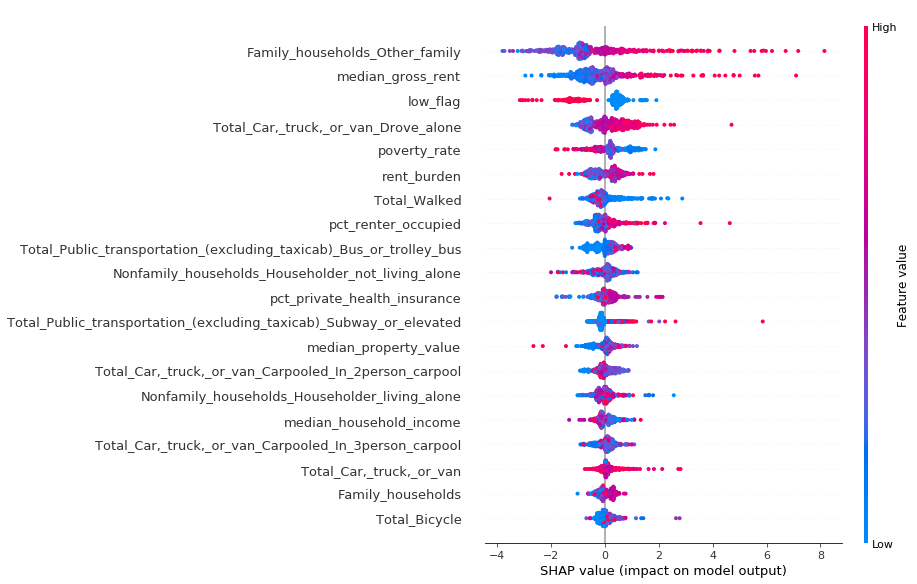

In [21]:
shap.summary_plot(shap_valuesp, Xp_test)

In [22]:
shap.force_plot(explainerp.expected_value, shap_valuesp[2,:], Xp_test.iloc[2,:])

# Predict evictions with protected class variables included

In [23]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

params = {
    "eta": 0.5,
    "max_depth": 3,
    "objective": "reg:linear",
    'min_samples_leaf': 30,
    'min_samples_split': 100,
    'n_estimators': 80,
    "silent": 1,
    "base_score": np.mean(y_train),
    "eval_metric": "rmse",
    'max_features': 'sqrt'
}

#old_params = {
#    "max_bin": 512,
#    "learning_rate": 0.05,
#    "boosting_type": "gbdt",
#    "objective": "binary",
#    "metric": "binary_logloss",
#    "num_leaves": 10,
#    "verbose": -1,
#    "min_data": 100,
#    "boost_from_average": True,
#    "random_state": random_state
#}

model = xgb.train(params, d_train, 10000, [(d_train,'train'),(d_test,'valid')], 
                  early_stopping_rounds=200, verbose_eval=1000)

[0]	train-rmse:4.36792	valid-rmse:3.45373
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[1]	train-rmse:3.80273	valid-rmse:3.27024



In [24]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

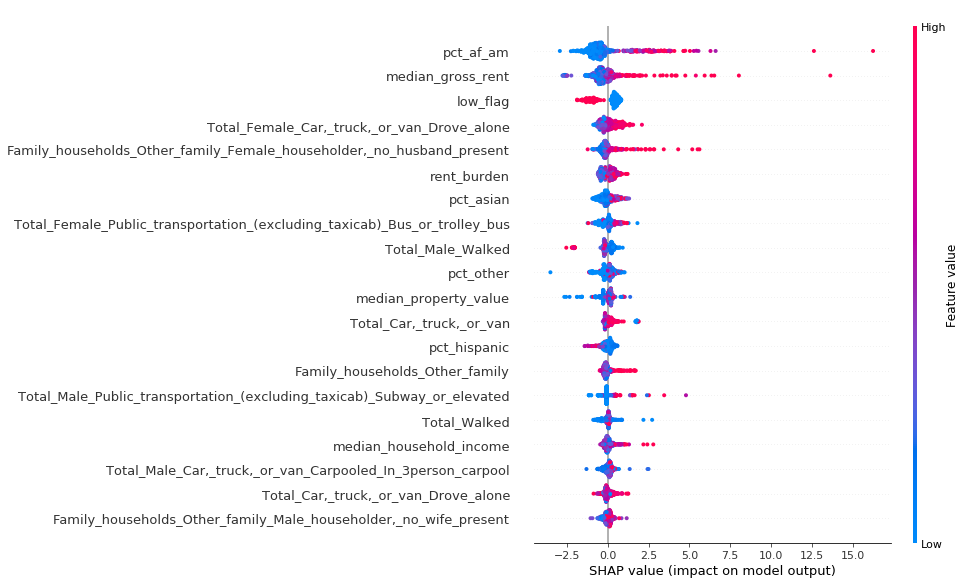

In [25]:
shap.summary_plot(shap_values, X_test)

In [26]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:])

# Compare both models recommendations for impact on protected classes

In [27]:
X_test_geo['predictions_with_all_inputs'] = model.predict(d_test)
X_test_geo['predictions_exclude_protected_classes'] = modelp.predict(dp_test)

In [35]:
corr_X = X_test_geo.corr()

In [38]:
corr_X.loc['pct_white','predictions_with_all_inputs']

-0.29524266996266063

In [36]:
corr_X.loc['pct_af_am','predictions_with_all_inputs']

0.42524622105150806

In [37]:
corr_X.loc['pct_af_am','predictions_exclude_protected_classes']

0.37918101159810585

In [29]:
import seaborn as sns

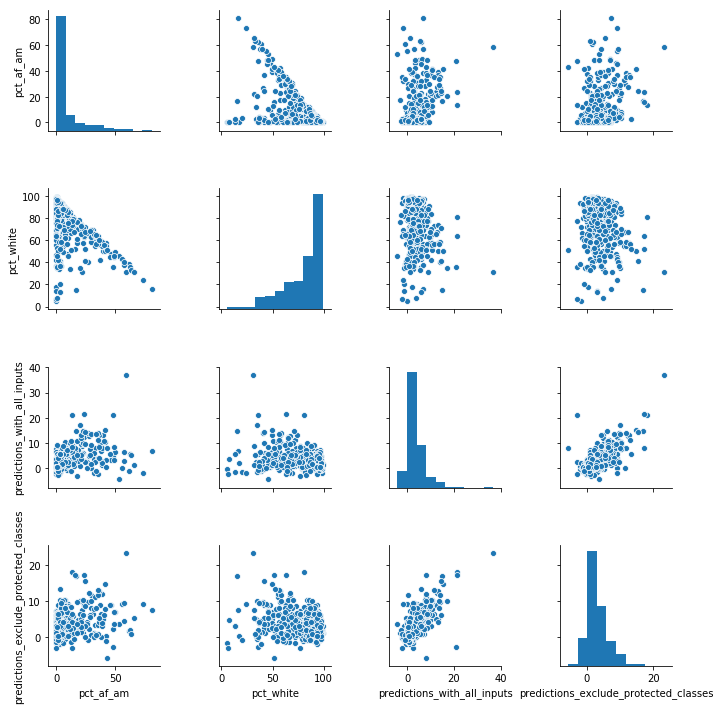

In [32]:
sns.pairplot(X_test_geo[['pct_af_am','pct_white','predictions_with_all_inputs','predictions_exclude_protected_classes']])

In [ ]:
X_test_geo.sort_values(by=['pct_af_am'],ascending=False)

In [ ]:
X_test.sort_values(by=['pct_af_am'], ascending=False)[:20]

In [ ]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print("Explainer expected value: {}".format(expected_value))

select = range(20)
features = X_test.iloc[select]
features_display = X.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

In [ ]:
shap_values

In [ ]:
shap.summary_plot(shap_values,X_test)

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display)

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display, link='logit')

In [ ]:
#example code
from pprint import pprint
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pickle
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
import warnings

X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "random_state": random_state
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

In [ ]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print("Explainer expected value: {}".format(expected_value))

select = range(20)
features = X_test.iloc[select]
features_display = X_display.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display)

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display, link='logit')

# Other data categories

In [ ]:
#TODO: Incorporate travel time
#DON'T USE???
df_travel = pd.read_csv('data/census/AGGREGATE TRAVEL TIME TO WORK/ACS_16_5YR_B08135_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_travel.columns = df_travel.columns.droplevel(0)
renames = {}
for col in df_travel.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]

df_travel = df_travel.rename(columns = renames)

drops = ['Id','Geography']
for col in df_travel.columns:
    if 'Margin' in col:
        drops.append(col)
        
df_travel.drop(drops, axis=1, inplace = True)
df_travel.dropna(inplace=True)

In [ ]:
#TODO: incorporate transportation by age
#DON'T INCLUDE???
df_transage = pd.read_csv('data/census/MEANS OF TRANSPORTATION TO WORK BY AGE/ACS_16_5YR_B08101_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_transage.columns = df_transage.columns.droplevel(0)

renames = {}
for col in df_transage.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]
df_transage = df_transage.rename(columns = renames)

drops = ['Id','Geography']
for col in df_transage.columns:
    if 'Margin' in col:
        drops.append(col)
df_transage.drop(drops, axis=1, inplace = True)
df_transage.dropna(inplace=True)

In [ ]:
#TODO: incorporate transportation by poverty status
#DON'T INCLUDE????
df_transpov = pd.read_csv('data/census/MEANS OF TRANSPORTATION TO WORK BY POVERTY STATUS/ACS_16_5YR_B08122_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_transpov.columns = df_transpov.columns.droplevel(0)

renames = {}
for col in df_transpov.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]
df_transpov = df_transpov.rename(columns = renames)

drops = ['Id','Geography']
for col in df_transpov.columns:
    if 'Margin' in col:
        drops.append(col)
df_transpov.drop(drops, axis=1, inplace = True)
df_transpov.dropna(inplace=True)